In [66]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_quad_no_constraint import *
import ciropt as co

In [67]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 6
problem_spec['vector_size'] = 10
# problem_spec['vector_size'] = 50
problem_spec['sc_theta'] = 1
problem_spec['sc_perturb'] = True
# problem_spec['sc_index_set'] = {0,1,2,3,4,5}
problem_spec['sc_index_set'] = {3,4}
# problem_spec['sc_index_set'] = {}
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()
problem_data['itr_num'] = 1000


{'n_node': 6, 'vector_size': 10, 'sc_theta': 1, 'sc_perturb': True, 'sc_index_set': {3, 4}}


In [68]:
Q = problem_data['Q']
b = problem_data['b']
n_node = problem_spec['n_node']
vector_size = problem_spec['vector_size']
sc_index_set = problem_spec['sc_index_set']

for j in range(n_node):
    U, s, V = np.linalg.svd(Q[j])
    print([np.max(s), np.average(s), np.min(s)])

[0.3405863206927442, 0.12957518461608636, 0.0025719666384295685]
[0.5274069977190222, 0.13768501945306097, 9.742616763465557e-06]
[0.6264536969032102, 0.17410177421890888, 0.0010103525990530571]
[8.88977440835516, 3.845970994379955, 0.15104900372947092]
[11.189494857622012, 4.213222549203832, 0.014763307449643149]
[0.45764700697092076, 0.15487248278006713, 1.3259541451736755e-06]


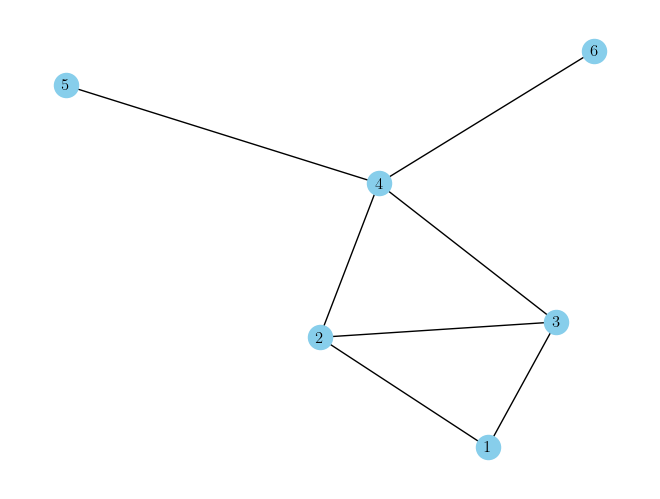

In [69]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True)
plt.savefig("plots/graph_n6.pdf")

In [70]:
f_star, x_opt_star = min_cvx_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-0.001898028963149634, np.linalg.norm(x_opt_star)=0.02793032433972044


In [71]:
f_star, x_opt_star = min_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-0.0018980289631496338, np.linalg.norm(x_opt_star)=0.027930324339720446


In [72]:
Q = problem_data['Q']
b = problem_data['b']
 
vector_size = problem_spec['vector_size']
n_node = problem_spec['n_node']
prox_operators = []
fi_operators = []

# Define functions and proximal operators to implement the method
for jj in range(n_node):
    Qj = Q[jj]
    bj = b[jj]
    # prox_operators += [lambda z, rho: cvx_prox_fj_quad_no_constraint(z, rho, problem_spec, problem_data, jj) ]
    prox_operators += [lambda z, rho, Qj=Qj, bj=bj, vector_size=vector_size : prox_fj_quad_no_constraint(z, rho, Qj, bj, vector_size) ]
    fi_operators += [lambda x_kj, Qj=Qj, bj=bj : 1/2 * x_kj @ Qj @ x_kj.T + np.dot(bj[0], x_kj) ]

    c = np.random.randn(vector_size)
    x1 = prox_operators[-1](c, 1/5)
    x2 = cvx_prox_fj_quad_no_constraint(c, 1/5, problem_spec, problem_data, jj, eps=1e-4)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5

In [73]:
# problem_data['rho'] = 1
# params={"R":1, "Capacitance":1, "h":0.561455037879421}

# pg_c_op_norm, pg_c_err_opt_star, pg_c_err_opt_reldiff, pg_c_const_vio, pg_c_f_reldiff = co.pg_extra("pg_extra_c", problem_spec, problem_data, 
#                                                                         network_data, x_opt_star, f_star, prox_operators=prox_operators,
#                                                                         fi_operators=fi_operators,
#                                                                         params=params, printing=True, sc_index_set = sc_index_set, freq=200)

In [74]:
# apply P-EXTRA 
best_rho = 1
find_best = True

# problem_data['rho'] = 0.01
# problem_data['rho'] = 0.1
# problem_data['rho'] = 0.2
# problem_data['rho'] = 0.5

# start = 0.2
start = 0.1
end = 2
space = 0.1

best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        problem_data['rho'] = round(r, 2)
        # print("Testing rho :", r)
        pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        printing=False, freq=200)
        # new_val = sum(pg_f_reldiff[-10:]) / 10
        # new_val = sum(pg_f_reldiff[-300:]) / 300
        # new_val = sum(pg_f_reldiff[-300:-200]) / 100
        new_val = sum(pg_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_rho :", round(r, 2),  "new best_value :", new_val)
            best_value = new_val
            best_rho = round(r, 2)

print("best_rho :",best_rho)

new best_rho : 0.1 new best_value : 2.8761421701612842e-08
new best_rho : 0.2 new best_value : 2.9948433862874194e-09
new best_rho : 0.3 new best_value : 1.9437944513755308e-09
new best_rho : 0.4 new best_value : 1.2917523347072415e-09
new best_rho : 0.5 new best_value : 7.908347396234756e-10
best_rho : 0.5


In [75]:
problem_data['rho'] = best_rho
# problem_data['rho'] = 1


# pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_quad_no_constraint(problem_spec, problem_data, network_data, x_opt_star, f_star, printing=True, freq=200)

pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        printing=True, freq=200)

ii=0, f_reldiff[-1]=0.328782951985841, err_opt_reldiff[-1]=0.5434653346771497
ii=200, f_reldiff[-1]=1.666946206408054e-06, err_opt_reldiff[-1]=1.4713887436506506e-06
ii=400, f_reldiff[-1]=1.6332016926932285e-11, err_opt_reldiff[-1]=1.950360717454476e-11
ii=600, f_reldiff[-1]=2.056411096314818e-15, err_opt_reldiff[-1]=1.2974254302342628e-14
ii=800, f_reldiff[-1]=1.599430852689303e-15, err_opt_reldiff[-1]=1.6936411761363487e-14
ii=999, f_reldiff[-1]=1.3709407308765454e-15, err_opt_reldiff[-1]=2.035062834413069e-14


In [76]:
best_R = 1
find_best = True

# R = 18
start = 1
end = 4
space = 0.2
# end = 2
# space = 0.1

best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        R = round(r, 2)
        # print("Testing R :", r)
        admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=False, freq=200)
        # new_val = sum(admm_f_reldiff[-10:]) / 10
        # new_val = sum(admm_f_reldiff[-300:]) / 300
        # new_val = sum(admm_f_reldiff[-300:-200]) / 100
        new_val = sum(admm_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_R :", round(r, 2),  ", new best_value :", new_val)
            best_value = new_val
            best_R = round(r, 2)

print("best_R :", best_R)

new best_R : 3.0 , new best_value : 1.26527557526536e-08
best_R : 3.0


In [77]:
R = best_R
# R = 3
# R = 2
# R = 1
# R = 0.5
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        params={"R":R}, printing=True, freq=200)


ii=0, f_reldiff[-1]=7.861145528126219
ii=200, f_reldiff[-1]=1.0379383004536044e-05
ii=400, f_reldiff[-1]=4.096201821168976e-10
ii=600, f_reldiff[-1]=1.8964680110458878e-14
ii=800, f_reldiff[-1]=4.569802436255151e-16
ii=999, f_reldiff[-1]=1.1424506090637878e-16


In [116]:
problem_data['rho'] = best_rho
# params={"R":1, "Capacitance":1, "h":0.561455037879421}
# params={"R":best_rho, "Capacitance":1, "h":0.561455037879421}
# params={"R":1, "Capacitance":0.1, "h":0.5}
params={"R":best_rho, "Capacitance":0.2, "h":0.5}

# problem_data['rho'] = 0.0001
# params={"R":best_rho, "Capacitance":0.1, "h":0.7}

best_value = 1

best_C = 0.2
start_C = 0.2
space_C = 0.2
end_C = 20

best_R = 0.2
start_R = 0.1
space_R = 0.1
end_R = 2

if find_best == True:
    for R in np.arange(start_R, end_R, space_R) :
        for c in np.arange(start_C, end_C, space_C) :
            C = round(c, 2)
            params={"R":R, "Capacitance":C, "h":0.5}
            # print("Testing R :", r)
            pg_c_op_norm, pg_c_err_opt_star, pg_c_err_opt_reldiff, pg_c_const_vio, pg_c_f_reldiff = co.pg_extra("pg_extra_c", problem_spec, problem_data, 
                                                                            network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                            fi_operators=fi_operators,
                                                                            params=params, printing=False, sc_index_set = sc_index_set, freq=200)
            # new_val = sum(admm_f_reldiff[-10:]) / 10
            # new_val = sum(admm_f_reldiff[-300:]) / 300
            # new_val = sum(admm_f_reldiff[-300:-200]) / 100
            new_val = sum(admm_f_reldiff[300:400]) / 100
            if new_val < best_value:
                print("new best_C :", round(C, 2), "new best_R :", round(R, 2),  ", new best_value :", new_val)
                best_value = new_val
                best_C = round(C, 2)
                best_R = round(R, 2)

params={"R":best_R, "Capacitance":best_C, "h":0.5}

pg_c_op_norm, pg_c_err_opt_star, pg_c_err_opt_reldiff, pg_c_const_vio, pg_c_f_reldiff = co.pg_extra("pg_extra_c", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        params=params, printing=True, sc_index_set = sc_index_set, freq=200)

new best_C : 0.2 new best_R : 0.1 , new best_value : 1.26527557526536e-08
ii=0, f_reldiff[-1]=6.150620238634933, err_opt_reldiff[-1]=0.6791315479780898
ii=200, f_reldiff[-1]=nan, err_opt_reldiff[-1]=inf
ii=400, f_reldiff[-1]=nan, err_opt_reldiff[-1]=nan
ii=600, f_reldiff[-1]=nan, err_opt_reldiff[-1]=nan
ii=800, f_reldiff[-1]=nan, err_opt_reldiff[-1]=nan
ii=999, f_reldiff[-1]=nan, err_opt_reldiff[-1]=nan


In [79]:
# problem_data['rho'] = best_rho
# params['S'] = 1
# params['S'] = -0.1

# pg_R_op_norm, pg_R_err_opt_star, pg_R_err_opt_reldiff, pg_R_const_vio, pg_R_f_reldiff = co.pg_extra("pg_extra_R", problem_spec, problem_data, 
#                                                                         network_data, x_opt_star, f_star, prox_operators=prox_operators,
#                                                                         fi_operators=fi_operators,
#                                                                         params=params, printing=True, sc_index_set = sc_index_set, freq=200)

c:\Users\jacks\anaconda3\Lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


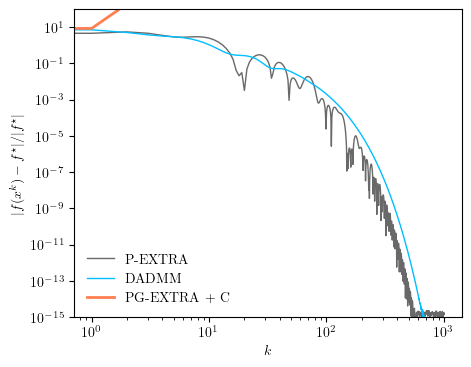

In [115]:
fname = "n6_qp_circuit_pg_c"

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 4
plt.rcParams["legend.framealpha"] = 0.0
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["mathtext.fontset"] = 'cm' # default = 'dejavusans', other options = 'cm', 'stixsans', 'dejavuserif'
black, red, blue, green = 'dimgrey', 'coral', 'deepskyblue', 'green'

# operator norm plot (log-log plot)
plt.figure(figsize=(5,4))
plt.minorticks_off()
plt.xscale("log")
plt.yscale("log")
plt.plot(pg_f_reldiff, label='P-EXTRA', color=black, linewidth=1)
plt.plot(admm_f_reldiff, label='DADMM', color=blue, linewidth=1)
# plt.plot(dadmm_c_all_f_reldiff, label='Circuit DADMM + C-All',  color=green, linewidth=1)
# plt.plot(dadmm_c_f_reldiff, label='Circuit DADMM + C',  color=red, linewidth=2)
plt.plot(pg_c_f_reldiff, label='PG-EXTRA + C',  color=red, linewidth=2)
# plt.plot(pg_R_f_reldiff, label='PG-EXTRA + R',  color=red, linewidth=2)
plt.xlabel(r"$k$")
plt.ylabel(r"$|f(x^k) - f^\star|/|f^\star|$")
# plt.ylabel(r"$\|\tilde{\mathbf{A}}x_k\|^2_M$")
plt.ylim(1e-15, 1e+2)
# plt.autoscale(enable=True, axis='y', tight=None)
plt.legend()
plt.savefig(f'plots/freldif_{fname}.pdf', dpi=300)